In [12]:
import os
os.environ["FIONA_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-fiona/gl_quads"
os.environ["FIONA_GL2D_STRICT"] = "0"
os.environ["OMP_NUM_THREADS"] = "112"

import pathlib, time, numpy as np, matplotlib.pyplot as plt
from fiona import SIS, PointLens, set_num_threads, FresnelNUFFT3
from fiona.utils import *

from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

set_num_threads(112)

def make_glow_lens_from_fiona(lens):
    """
    Construct the corresponding GLoW Psi_* lens from a FIONA lens instance.

    FIONA:
      - SIS(psi0):          ψ(r) = psi0 * r
      - PointLens(psi0,xc): ψ(r) = 0.5*psi0*log(r^2 + xc^2)

    GLoW:
      - Psi_SIS({'psi0':...}, {})
      - Psi_PointLens({'psi0':...}, {'xc':...})   (Plummer-softened point lens)
    """
    if isinstance(lens, SIS):
        return glow_lenses.Psi_SIS({"psi0": float(lens.psi0)}, {})

    if isinstance(lens, PointLens):
        return glow_lenses.Psi_PointLens(
            {"psi0": float(lens.psi0)},
            {"xc": float(lens.xc)},
        )

    raise TypeError(f"GLoW lens mapping not implemented for {type(lens).__name__}")

    
def plot_overlays_ws(
    ws,
    F_fiona,
    F_glow,
    quad_label,
    max_physical_radius,
    title="F(w) overlay",
    align_phase=True,
    y_log=False,
    spline=True,
    spline_method="cubic",  # "cubic" or "smooth"
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    """
    Overlay plot for scalar F(w) from FIONA vs GLoW.
    Linear frequency axis + optional spline-smoothed curves.
    """
    if align_phase:
        F_fiona_aligned, _ = align_global_phase(F_fiona, F_glow)
    else:
        F_fiona_aligned = F_fiona
        
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,})

    ws = np.asarray(ws)
    mag_fiona = np.abs(F_fiona_aligned)
    mag_glow = np.abs(F_glow)

    plt.figure()

    if spline:
        wmin, wmax = float(np.min(ws)), float(np.max(ws))
        n_fine = max(int(len(ws) * fine_factor), 200)
        ws_fine = np.linspace(wmin, wmax, n_fine)

        mag_fiona_s = spline_fit_eval(ws, mag_fiona, ws_fine, method=spline_method, smooth_s=spline_s)
        mag_glow_s  = spline_fit_eval(ws, mag_glow,  ws_fine, method=spline_method, smooth_s=spline_s)

        plt.plot(ws_fine, mag_fiona_s, "-",  label="FIONA", color="orchid")
        plt.plot(ws_fine, mag_glow_s,  "--", label="GLoW",  color="royalblue")
    else:
        plt.plot(ws, mag_fiona, "-",  label="FIONA", color="orchid")
        plt.plot(ws, mag_glow,  "--", label="GLoW",  color="royalblue")

    if y_log:
        plt.yscale("log")

    plt.xlabel("$\omega$")
    plt.ylabel("$|F(\omega)|$")
    plt.legend(loc="upper right")
    #plt.title(f"{title}; {quad_label}, R={max_physical_radius}")
    plt.show()


def compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                            w_grid=np.linspace(0.1, 10.0, 200),
                            y_star=1.2,
                            # computation settings (NEW API)
                            gl_nodes_per_dim=2000,
                            max_physical_radius=100.0,
                            nufft_tol=1e-12,
                            batch_frequencies=True,
                            chunk_frequencies=True,
                            frequency_binning="log",     # "log" or "linear"
                            frequency_bin_width=0.5,     # decades if log, |w| units if linear
                            auto_R_from_gl_nodes=True,
                            use_tail_correction=True,
                            coordinate_system="cartesian",  # "cartesian" or "polar"
                            polar_radial_nodes=None,
                            polar_angular_nodes=None,
                            uniform_angular_sampling=True,
                            numexpr_nthreads=None,
                            verbose=True,
                            # plotting settings
                            y_log=False,
                            spline=True,
                            spline_method="smooth",  # "cubic" or "smooth"
                            spline_s=None,
                            fine_factor=10,
                            font_size=15,
                        ):
    # Label for plot
    if coordinate_system == "polar":
        quad_label = f"$N_r={polar_radial_nodes}$, $N_{{\\theta}}={polar_angular_nodes}$"
    else:
        quad_label = f"$N_{{GL}}={gl_nodes_per_dim}$"

    # ---- FIONA ----
    t0 = time.perf_counter()
    nu3v = FresnelNUFFT3(
        lens,
        gl_nodes_per_dim=gl_nodes_per_dim,
        max_physical_radius=max_physical_radius,
        nufft_tol=nufft_tol,
        batch_frequencies=batch_frequencies,
        chunk_frequencies=chunk_frequencies,
        frequency_binning=frequency_binning,
        frequency_bin_width=frequency_bin_width,
        auto_R_from_gl_nodes=auto_R_from_gl_nodes,
        use_tail_correction=use_tail_correction,
        coordinate_system=coordinate_system,
        polar_radial_nodes=polar_radial_nodes,
        polar_angular_nodes=polar_angular_nodes,
        uniform_angular_sampling=uniform_angular_sampling,
        numexpr_nthreads=numexpr_nthreads,
        verbose=verbose,
    )

    # FIONA call signature: nu3v(w, y1, y2, verbose=None)
    F_fiona = nu3v(w_grid, np.array([y_star]), np.array([0.0]))[:, 0]
    t1 = time.perf_counter()
    fiona_s = t1 - t0

    # ---- GLoW ----
    t2 = time.perf_counter()

    Psi = make_glow_lens_from_fiona(lens)

    It = time_domain_c.It_MultiContour_C(Psi, y=y_star)
    Fw = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)

    t3 = time.perf_counter()
    glow_s = t3 - t2

    # ---- Plot ----
    plot_overlays_ws(
        w_grid,
        F_fiona,
        F_glow,
        quad_label=quad_label,
        max_physical_radius=max_physical_radius,
        title=f"{type(lens).__name__} @ y={y_star}",
        align_phase=True,
        y_log=y_log,
        spline=spline,
        spline_method=spline_method,
        spline_s=spline_s,
        fine_factor=fine_factor,
        font_size=font_size
    )

    print(f"FIONA time (single run): {fiona_s:.4f} s")
    print(f"GLoW time (single run): {glow_s:.4f} s")
    print(f"Speedup (GLoW/FIONA): {glow_s/fiona_s:.2f}×")


[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[chunk 1/6] count=1 | |w| in [0.01, 0.01] | N=2000 fixed -> R=316.228, Umax=3.16228, h=0.993459 | binning=log10(|w|), Δ=0.5 decades
[chunk 2/6] count=1 | |w| in [0.060201, 0.060201] | N=2000 fixed -> R=128.884, Umax=7.75893, h=0.4049 | binning=log10(|w|), Δ=0.5 decades
[chunk 3/6] count=5 | |w| in [0.110402, 0.311206] | N=2000 fixed -> R=56.686, Umax=17.641, h=0.178084 | binning=log10(|w|), Δ=0.5 decades
[chunk 4/6] count=13 | |w| in [0.361407, 0.963819] | N=2000 fixed -> R=32.2109, Umax=31.0454, h=0.101193 | binning=log10(|w|), Δ=0.5 decades
[chunk 5/6] count=43 | |w| in [1.01402, 3.12246] | N=2000 fixed -> R=17.8958, Umax=55.879, h=0.0562214 | binning=log10(|w|), Δ=0.5 decades
[chunk 6/6] count=137 | |w| in [3.17266, 10] | N=2000 fixed -> R=10, Umax=100, h=0.0314159 | binning=log10(|w|), Δ=0.5 decades


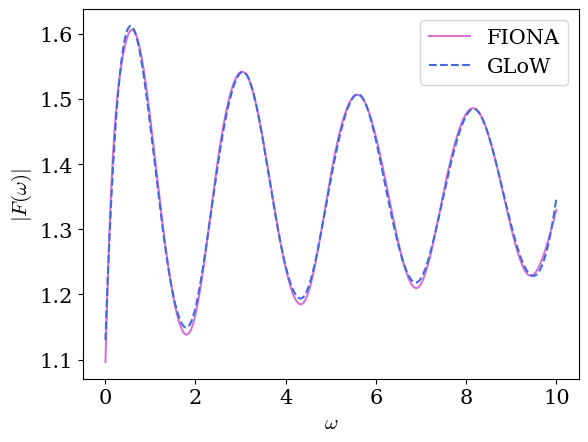

FIONA time (single run): 27.4144 s
GLoW time (single run): 0.0124 s
Speedup (GLoW/FIONA): 0.00×


In [10]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        gl_nodes_per_dim=2000,
                        w_grid=np.linspace(0.01, 10.0, 200),
                        y_star=1.2,
                        max_physical_radius=500.0,
                        nufft_tol=1e-12,
                        batch_frequencies=True,
                        chunk_frequencies=True,
                        numexpr_nthreads=64,
                        verbose=True,
                        coordinate_system="cartesian",
                        use_tail_correction=True,
                        auto_R_from_gl_nodes=True,
                        frequency_binning="log",
                        frequency_bin_width=0.5,
                        y_log=False,
                        spline=True,
                        spline_method="smooth",
                        spline_s=1e-2,
                        fine_factor=10,
                        font_size=15.)

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[chunk 1/6] count=1 | |w| in [0.01, 0.01] | N=5000 fixed -> R=500, Umax=5, h=0.628319 | binning=log10(|w|), Δ=0.5 decades
[chunk 2/6] count=1 | |w| in [0.060201, 0.060201] | N=5000 fixed -> R=203.783, Umax=12.2679, h=0.256081 | binning=log10(|w|), Δ=0.5 decades
[chunk 3/6] count=5 | |w| in [0.110402, 0.311206] | N=5000 fixed -> R=89.6285, Umax=27.8929, h=0.11263 | binning=log10(|w|), Δ=0.5 decades
[chunk 4/6] count=13 | |w| in [0.361407, 0.963819] | N=5000 fixed -> R=50.9298, Umax=49.0871, h=0.0640003 | binning=log10(|w|), Δ=0.5 decades
[chunk 5/6] count=43 | |w| in [1.01402, 3.12246] | N=5000 fixed -> R=28.2958, Umax=88.3525, h=0.0355575 | binning=log10(|w|), Δ=0.5 decades
[chunk 6/6] count=137 | |w| in [3.17266, 10] | N=5000 fixed -> R=15.8114, Umax=158.114, h=0.0198692 | binning=log10(|w|), Δ=0.5 decades


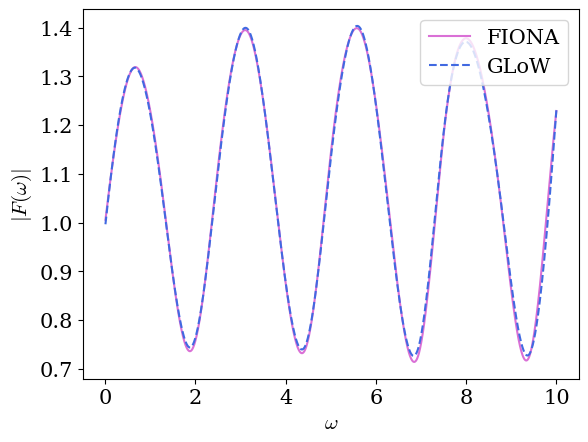

FIONA time (single run): 146.5638 s
GLoW time (single run): 0.0153 s
Speedup (GLoW/FIONA): 0.00×


In [13]:
compare_plot_GLoW_FIONA(lens=PointLens(psi0=1.0, xc=0.01),
                        gl_nodes_per_dim=5000,
                        w_grid=np.linspace(0.01, 10.0, 200),
                        y_star=1.2,
                        max_physical_radius=1000.0,
                        nufft_tol=1e-12,
                        batch_frequencies=True,
                        chunk_frequencies=True,
                        numexpr_nthreads=64,
                        verbose=True,
                        coordinate_system="cartesian",
                        use_tail_correction=True,
                        auto_R_from_gl_nodes=True,
                        frequency_binning="log",
                        frequency_bin_width=0.5,
                        y_log=False,
                        spline=True,
                        spline_method="smooth",
                        spline_s=5e-2,
                        fine_factor=10,
                        font_size=15.)